In [ ]:
#Setup Code

import csv
import warnings
import pickle
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice, chain, count, product
from contextlib import nullcontext
from concurrent.futures import ProcessPoolExecutor

data_dir = "../data"

import torch
import torch.utils.data
import coba as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from parameterfree import COCOB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

try:
    torch.set_num_threads(3)
    torch.set_num_interop_threads(3)
except RuntimeError:
    pass

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

torch.set_default_device('cpu')
plt.rc('font', **{'size': 20})

def make_emotions_df():

    def add_day_columns(df, timestamp_col, participant_df):
        return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

    def add_day(df, timestamp_col):
        df = df.copy()
        df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
        return df

    def add_start_day(df, participant_df):
        participant_df = participant_df.copy()
        participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
        return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

    def add_rel_day(df):
        df = df.copy()
        df["RelDay"] = df["Day"]-df["StartDay"]
        return df

    def drop_all1_ends(df):
        last, last_gt_1, keep = df.copy(),df.copy(), df.copy()
        
        last_gt_1 = last_gt_1[last_gt_1["State Anxiety"]!= 1]
        last_gt_1 = last_gt_1.groupby("ParticipantId")["RelDay"].max().reset_index()
        last_gt_1 = last_gt_1.rename(columns={"RelDay":"Last Day > 1"})

        last = last.groupby("ParticipantId")["RelDay"].max().reset_index()
        last = last.rename(columns={"RelDay":"Last Day"})

        for pid in last["ParticipantId"]:
            
            last_day = last[last["ParticipantId"]==pid]["Last Day"].item()
            last_day_gt_1 = last_gt_1[last_gt_1["ParticipantId"]==pid]["Last Day > 1"].item()
            
            if last_day-last_day_gt_1 >= 3:
                is_not_pid = keep["ParticipantId"] != pid
                is_lt_day  = keep["RelDay"] <= last_day_gt_1
                keep = keep[is_not_pid | is_lt_day]

        return keep

    emotions_df = pd.read_csv(f'{data_dir}/Emotions.csv')
    participant_df = pd.read_csv(f'{data_dir}/Participants.csv')

    emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

    emotions_df["State Anxiety"] = pd.to_numeric(emotions_df["State Anxiety"], errors='coerce')
    emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
    emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
    emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60
    emotions_df["Response Time (sec)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])
    emotions_df["Response Time (log min)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60)
    emotions_df["Response Time (log sec)"] = np.log((1+ emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"]))

    emotions_df["State Anxiety (z)"] = float('nan')
    emotions_df["ER Interest (z)"] = float('nan')

    for pid in set(emotions_df["ParticipantId"].tolist()):
        is_pid = emotions_df["ParticipantId"] == pid
        is_anx = emotions_df["State Anxiety"] > 1
        emotions_df.loc[is_pid,["ER Interest (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid,["ER Interest"]])
        emotions_df.loc[is_pid&is_anx,["State Anxiety (z)"]] = StandardScaler().fit_transform(emotions_df.loc[is_pid&is_anx,["State Anxiety"]])

    emotions_df = add_day_columns(emotions_df, "DeliveredTimestampUtc", participant_df)

    emotions_df = emotions_df[emotions_df["RelDay"] < 11]

    return drop_all1_ends(emotions_df)

emotions_df = make_emotions_df()

class TheoryGridCellSpatialRelationEncoder:
    #https://arxiv.org/pdf/2003.00824
    def __init__(self, coord_dim = 2, frequency_num = 16, max_radius = 10000,  min_radius = 1000, freq_init = "geometric"):
        """
        Args:
            coord_dim: the dimention of space, 2D, 3D, or other
            frequency_num: the number of different sinusoidal with different frequencies/wavelengths
            max_radius: the largest context radius this model can handle
        """

        self.frequency_num = frequency_num
        self.coord_dim = coord_dim 
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.freq_init = freq_init

        # the frequency we use for each block, alpha in ICLR paper
        self.cal_freq_list()
        
        # freq_mat shape: (frequency_num, 1)
        freq_mat = np.expand_dims(self.freq_list, axis = 1)
        # self.freq_mat shape: (frequency_num, 6)
        self.freq_mat = np.repeat(freq_mat, 6, axis = 1)

        # there unit vectors which is 120 degree apart from each other
        self.unit_vec1 = np.asarray([1.0, 0.0])                        # 0
        self.unit_vec2 = np.asarray([-1.0/2.0, np.sqrt(3)/2.0])      # 120 degree
        self.unit_vec3 = np.asarray([-1.0/2.0, -np.sqrt(3)/2.0])     # 240 degree

        # compute the dimention of the encoded spatial relation embedding
        self.input_embed_dim = int(6 * self.frequency_num)
        
    def cal_freq_list(self):
        if self.freq_init == "random":
            self.freq_list = np.random.random(size=[self.frequency_num]) * self.max_radius
        elif self.freq_init == "geometric":
            log_timescale_increment = (np.log(float(self.max_radius) / float(self.min_radius)) /(self.frequency_num*1.0 - 1))
            timescales = self.min_radius * np.exp(np.arange(self.frequency_num).astype(float) * log_timescale_increment)
            self.freq_list = 1.0/timescales
        else:
            raise Exception()

    def make_input_embeds(self, coords):
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:
            coords = [[c] for c in coords]
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")

        # (batch_size, num_context_pt, coord_dim)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]

        # compute the dot product between [deltaX, deltaY] and each unit_vec 
        # (batch_size, num_context_pt, 1)
        angle_mat1 = np.expand_dims(np.matmul(coords_mat, self.unit_vec1), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat2 = np.expand_dims(np.matmul(coords_mat, self.unit_vec2), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat3 = np.expand_dims(np.matmul(coords_mat, self.unit_vec3), axis = -1)

        # (batch_size, num_context_pt, 6)
        angle_mat = np.concatenate([angle_mat1, angle_mat1, angle_mat2, angle_mat2, angle_mat3, angle_mat3], axis = -1)
        # (batch_size, num_context_pt, 1, 6)
        angle_mat = np.expand_dims(angle_mat, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = np.repeat(angle_mat, self.frequency_num, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = angle_mat * self.freq_mat
        # (batch_size, num_context_pt, frequency_num*6)
        spr_embeds = np.reshape(angle_mat, (batch_size, num_context_pt, -1))

        # make sinuniod function
        # sin for 2i, cos for 2i+1
        # spr_embeds: (batch_size, num_context_pt, frequency_num*6=input_embed_dim)
        spr_embeds[:, :, 0::2] = np.sin(spr_embeds[:, :, 0::2])  # dim 2i
        spr_embeds[:, :, 1::2] = np.cos(spr_embeds[:, :, 1::2])  # dim 2i+1
        
        return spr_embeds.squeeze().tolist()

def is_gt(values,val):
    out = (values > val).astype(float)
    out[values.isna()] = float('nan')
    return out

def is_lt(values,val):
    out = (values < val).astype(float)
    out[values.isna()] = float('nan')
    return out

def scale(values):
    with warnings.catch_warnings():
        # If a column has all nan then a warning is thrown
        # We supress that warning because that can happen
        warnings.simplefilter("ignore")
        return StandardScaler().fit_transform(values).tolist()

def add1(X):
    for x,z in zip(X,np.isnan(X).all(axis=1).astype(int)):
        x.append(z)
    return X

def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) >= timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def dems(pid, timestamps):
    df = pd.read_csv(f'{data_dir}/Baseline.csv')
    i = df["pid"].tolist().index(pid)
    return df.to_numpy()[[i]*len(timestamps), 1:].tolist()

def cacher(sensor,pid,ts,maker,*args):
    filename = f"{sensor}_{int(sum(ts))}_{args}_{pid}.pkl"
    features = load_feats(filename)
    if features: return features
    features = maker(pid,ts,*args)
    save_feats(filename,features)
    return features

def hrs(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/HeartRate.csv", timestamps, secs):
        w = list(filter(None,w))
        if w: features.append([np.mean(w),np.std(w)])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'hrs'
    return scale(features)

def scs1(pid, timestamps, secs):
    features = []
    if features: return features

    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*2)
    assert len(set(map(len,features))) == 1, 'scs1'

    return scale(features)

def scs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/StepCount.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
    assert len(set(map(len,features))) == 1, 'scs2'
    return scale(features)

def lins1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins1'
    return scale(features)

def lins2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([*np.var(w,axis=0),*np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])])
        else: features.append([float('nan')]*6)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def lins3(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins3'
    return scale(features)

def lins4(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/watch/{pid}/LinearAcceleration.csv", timestamps, secs):
        if w: features.append([np.mean(np.linalg.norm(w,axis=1)), *np.std(w,axis=0)])
        else: features.append([float('nan')]*4)
    assert len(set(map(len,features))) == 1, 'lins2'
    return scale(features)

def bats1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if len(w)==1: features.append([0,float('nan'),float('nan')])
        elif len(w)>1: features.append([np.max(w)-np.min(w),np.mean(np.diff(w)),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'bats1'
    return features

def bats2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Battery.csv", timestamps, secs):
        w = [float(w)/100 for w in w]
        if w: features.append([np.mean(w),np.max(w)-np.min(w)])
        else: features.append([float('nan')]*2)
        assert len(set(map(len,features))) == 1, 'bats2'
    return features

def peds1(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)==1: features.append([float('nan'),0,float('nan')])
        elif len(w)>1: features.append([np.mean(np.diff(w)),np.max(w)-np.min(w),np.std(np.diff(w))])
        else: features.append([float('nan')]*3)
        assert len(set(map(len,features))) == 1, 'peds1'
    return scale(features)

def peds2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Pedometer.csv", timestamps, secs):
        if len(w)>1: features.append([np.max(w)-np.min(w)])
        else: features.append([float('nan')])
        assert len(set(map(len,features))) == 1, 'peds2'
    return scale(features)

def locs1(pid, timestamps, secs, freq, lmin, lmax):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    out = TheoryGridCellSpatialRelationEncoder(frequency_num=freq,min_radius=lmin,max_radius=lmax,freq_init='geometric').make_input_embeds(features)
    return [out] if len(timestamps) == 1 else out

def locs2(pid, timestamps, secs):
    features = []
    for w in wins(f"{data_dir}/phone/{pid}/Location.csv", timestamps, secs):
        if w: features.append([*np.mean(w,axis=0)[1:]])
        else: features.append([float('nan')]*2)
    return features

def tims(timestamps,tzs):
    hour, day = 60*60, 60*60*24
    for timestamp,tz in zip(timestamps,tzs):
        if np.isnan(timestamp): 
            yield [float('nan')]*3
        else:
            if   tz == "-04:00": timestamp -= 4*hour
            elif tz == "-05:00": timestamp -= 5*hour
            time_of_day = (timestamp/day) % 1
            day_of_week = (int(timestamp/day)+4) % 7
            is_weekend = day_of_week in [0,6]
            is_weekday = day_of_week in [1,2,3,4,5]
            yield [time_of_day,int(is_weekend),int(is_weekday)]

def save_feats(filename,feats):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        with open(f"{data_dir}/feats/{filename}", "wb") as f: # Use "wb" for binary write mode
            pickle.dump(feats, f)

def load_feats(filename):
    if not Path(f"{data_dir}/feats/{filename}").exists():
        return None
    else:
        try:
            with open(f"{data_dir}/feats/{filename}", "rb") as f: # Use "wb" for binary write mode
                return pickle.load(f)
        except:
            Path(f"{data_dir}/feats/{filename}").unlink()
            return None

def make_xyg1(work_item):
    (pid,ts,tz,ys,args,secs) = work_item

    fs = []

    if args[0]: fs.append(list(tims(ts,tz)))
    if args[1]: fs.append(list(cacher("hrs"  ,pid,ts,hrs  ,args[1])))
    if args[2]: fs.append(list(cacher("scs1" ,pid,ts,scs1 ,args[2])))
    if args[3]: fs.append(list(cacher("lins1",pid,ts,lins1,args[3])))
    if args[4]: fs.append(list(cacher("lins2",pid,ts,lins2,args[4])))
    if args[5]: fs.append(list(cacher("bats1",pid,ts,bats1,args[5])))
    if args[6]: fs.append(list(cacher("peds1",pid,ts,peds1,args[6])))
    if args[7]: fs.append(list(cacher("locs1",pid,ts,locs1,*args[7])))
    if args[8]: fs.append(list(cacher("locs2",pid,ts,locs2,args[8])))

    if args[10]:
        for f in fs: add1(f)

    if args[9]: fs.append(list(dems(pid,ts)))

    os = list(ys)
    xs = [list(chain.from_iterable(feats)) for feats in zip(*fs)]
    gs = [pid]*len(ys)

    for sec in (secs or []):
        nts = [t-sec for t in ts]
        nxs,nys,ngs = make_xyg2((pid,nts,tz,os,args,0))
        xs += nxs
        ys += nys
        gs += ngs

    return xs,ys,gs

def make_xyg2(work_item):
    (pid,ts,tz,ys,args,secs) = work_item

    fs = []

    if args[0]: fs.append(list(tims(ts,tz)))
    if args[1]: fs.append(list(cacher("hrs"  ,pid,ts,hrs  ,args[1])))
    if args[2]: fs.append(list(cacher("scs2" ,pid,ts,scs2 ,args[2])))
    if args[3]: fs.append(list(cacher("lins3",pid,ts,lins3,args[3])))
    if args[4]: fs.append(list(cacher("lins4",pid,ts,lins4,args[4])))
    if args[5]: fs.append(list(cacher("bats2",pid,ts,bats2,args[5])))
    if args[6]: fs.append(list(cacher("peds2",pid,ts,peds2,args[6])))
    if args[7]: fs.append(list(cacher("locs1",pid,ts,locs1,*args[7])))
    if args[8]: fs.append(list(cacher("locs2",pid,ts,locs2,args[8])))

    if args[10]:
        for f in fs: add1(f)

    if args[9]: fs.append(list(dems(pid,ts)))

    os = list(ys)
    xs = [list(chain.from_iterable(feats)) for feats in zip(*fs)]
    gs = [pid]*len(ys)

    for sec in (secs or []):
        nts = [t-sec for t in ts]
        nxs,nys,ngs = make_xyg2((pid,nts,tz,os,args,0))
        xs += nxs
        ys += nys
        gs += ngs

        assert len(xs) == len(ys)
        assert len(ys) == len(gs)

    return xs,ys,gs

can_predict = emotions_df.copy().sort_values(["ParticipantId","DeliveredTimestampUtc"])

def work_items(tims:bool,hrs:int,scs:int,lins1:int,lins2:int,bats:int,peds:int,locs1,locs2:int,dems:bool,add1:bool,event:str,secs=0):

    df = can_predict[~can_predict["SubmissionTimestampUtc"].isna()]

    if isinstance(secs,int): secs = [secs]

    for pid in sorted(df["ParticipantId"].drop_duplicates().tolist()):
        ptc  = df[df.ParticipantId == pid]
        tss  = ptc["SubmissionTimestampUtc" if event == "sub" else "DeliveredTimestampUtc"].tolist() 
        tzs  = ptc["LocalTimeZone"].tolist()

        y0s = torch.tensor(is_gt(ptc["ER Interest (z)"],0).tolist())
        y1s = torch.tensor(is_lt(ptc['Response Time (min)'],10).tolist())
        y2s = torch.tensor(is_gt(ptc["State Anxiety (z)"],0).tolist())
        y3s = torch.tensor(is_gt(ptc["State Anxiety"], 1).tolist())
        y4s = torch.tensor(ptc["Response Time (log sec)"].tolist())
        y5s = torch.tensor(ptc["ER Interest (z)"].tolist())
        y6s = torch.tensor(ptc["State Anxiety (z)"].tolist())

        ys = torch.hstack((
            y0s.unsqueeze(1),
            y1s.unsqueeze(1),
            y2s.unsqueeze(1),
            y3s.unsqueeze(1),
            y4s.unsqueeze(1),
            y5s.unsqueeze(1),
            y6s.unsqueeze(1)
        )).tolist()

        args = [tims,hrs,scs,lins1,lins2,bats,peds,locs1,locs2,dems,add1]

        yield pid,tss,tzs,ys,args,secs

#with ProcessPoolExecutor(max_workers=20) as executor:
X,Y,G = zip(*map(make_xyg2, work_items(True,0,0,300,0,300,300,[300,2,1,2],0,False,True,"del")))

X  = torch.tensor(list(chain.from_iterable(X))).float()
Y  = torch.tensor(list(chain.from_iterable(Y))).float()
G  = torch.tensor(list(chain.from_iterable(G))).int()

any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
X = X[~any_na]
Y = Y[~any_na].float()
G = G[~any_na]

outer_gs = []
inner_gs = []

testable_G = cb.CobaRandom(1).shuffle([k for k,v in Counter(G.tolist()).items() if v >= 10])

for i in range(int(np.ceil(len(testable_G)/3))):
    outer_gs.append(testable_G[i*3:(i+1)*3])


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

x = [0]
y = [0]
L = [[0],[1]]
A = product([True],x,x,x,x,x,x,y,[0],[False],[True],["del"])

envs = [ MyEnvironment(a,L,g,rng) for a in A for g in outer_gs for rng in range(1) ]
lrns = [ None ]
vals = [ MyEvaluator((), (), ('1',1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, [3]) ]

cb.Experiment(envs,lrns,vals).run('../logs/2/offnp-baseline.log.gz',processes=38,quiet=True) #type: ignore

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

x = [0,300]
y = [0,300]
L = [[0],[1],[0,1]]
d = [True,False]
A = product([True],x,x,x,x,x,x,y,[0],d,[True],["del"])

envs = [ MyEnvironment(a,L,g,rng) for a in A for g in outer_gs for rng in range(2) ]
lrns = [ None ]
vals = [ MyEvaluator((), ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []) ]

cb.Experiment(envs,lrns,vals).run('../logs/2/offnp-feats.log.gz',processes=38,quiet=True) #type: ignore

{'Learners': 1, 'Environments': 11264, 'Interactions': 22528}


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 300, 0, False, True, 'del'),[[0]], g, rng) for g in outer_gs for rng in range(4) ]
env2 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 300, 0, False, False, 'del'),[[0]], g, rng) for g in outer_gs for rng in range(4) ]

envs = env1 + env2
lrns = [ None ]
vals = [
    MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',25,'l','r','x'), (25,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',23,'l','r','x'), (23,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',26,'l','r','x'), (26,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
]

cb.Experiment(envs,lrns,vals).run('../logs/2/offnp-ae-interest2.log.gz',processes=38,quiet=True) #type: ignore

{'Learners': 1, 'Environments': 176, 'Interactions': 1408}


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 0, 0, False, True, 'del'),[[0]], g, 1) for g in outer_gs ]
env2 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 0, 0, False, False, 'del'),[[0]], g, 1) for g in outer_gs ]

envs = env1 + env2
lrns = [ None ]
vals = [
    MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 100, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',12,'l','r','x'), (12,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
]

cb.Experiment(envs,lrns,vals).run('../logs/2/offnp-ae-interest2.log.gz',processes=38,quiet=True) #type: ignore

{'Learners': 1, 'Environments': 32, 'Interactions': 192}


In [15]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((False, 0, 300, 300, 0, 300, 0, 0, 0, False, True, 'del'),[[0]], g, 1) for g in outer_gs ]
env2 = [ MyEnvironment((False, 0, 300, 300, 0, 300, 0, 0, 0, False, False, 'del'),[[0]], g, 1) for g in outer_gs ]

envs = env1 + env2
lrns = [ None ]
vals = [
    MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 100, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',12,'l','r','x'), (12,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
]

cb.Experiment(envs,lrns,vals).run('../logs/2/offnp-ae-interest3.log.gz',processes=38,quiet=True) #type: ignore

{'Learners': 1, 'Environments': 32, 'Interactions': 192}


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

#                     [True, 0, 300, 300, 0, 300, 0, 300, 0, False, True, 'del']
#                     [True, 0,   0, 300, 0, 300, 0, 300, 0, False, True, 'del']
env1 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 300, 0, False, True, 'del'),[[0]], g, 1) for g in outer_gs ]
env2 = [ MyEnvironment((True, 0, 300, 300, 0, 300, 0, 300, 0, False, False, 'del'),[[0]], g, 1) for g in outer_gs ]

envs = env1 + env2
lrns = [ None ]
vals = [
    #MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 100, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    #MyEvaluator(('x',12,'l','r','x'), (12,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
]

cb.Experiment(envs,lrns,vals).run(processes=38,quiet=True) #type: ignore
np.nanpercentile(sum(res.interactions["g[0]-auc0"],()),[10,50,90]).round(2)

{'Learners': 1, 'Environments': 32, 'Interactions': 192}


In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G

        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 300, 300, 0, 300, 0, 300, 300, 0, False, True, 'del'),[[1]], g, 1) for g in outer_gs ]
env2 = [ MyEnvironment((True, 300, 300, 0, 300, 0, 300, 300, 0, False, False, 'del'),[[1]], g, 1) for g in outer_gs ]

envs = env1+env2
lrns = [ None ]
vals = [
    MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,1), 100, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',27,'l','r','x'), (27,'l','r',90,'l','r'), (90,1), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,1), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
]

cb.Experiment(envs,lrns,vals).run("../logs/2/offnp-ae-response2.log.gz",processes=20,quiet=True) #type: ignore

{'Learners': 1, 'Environments': 32, 'Interactions': 192}


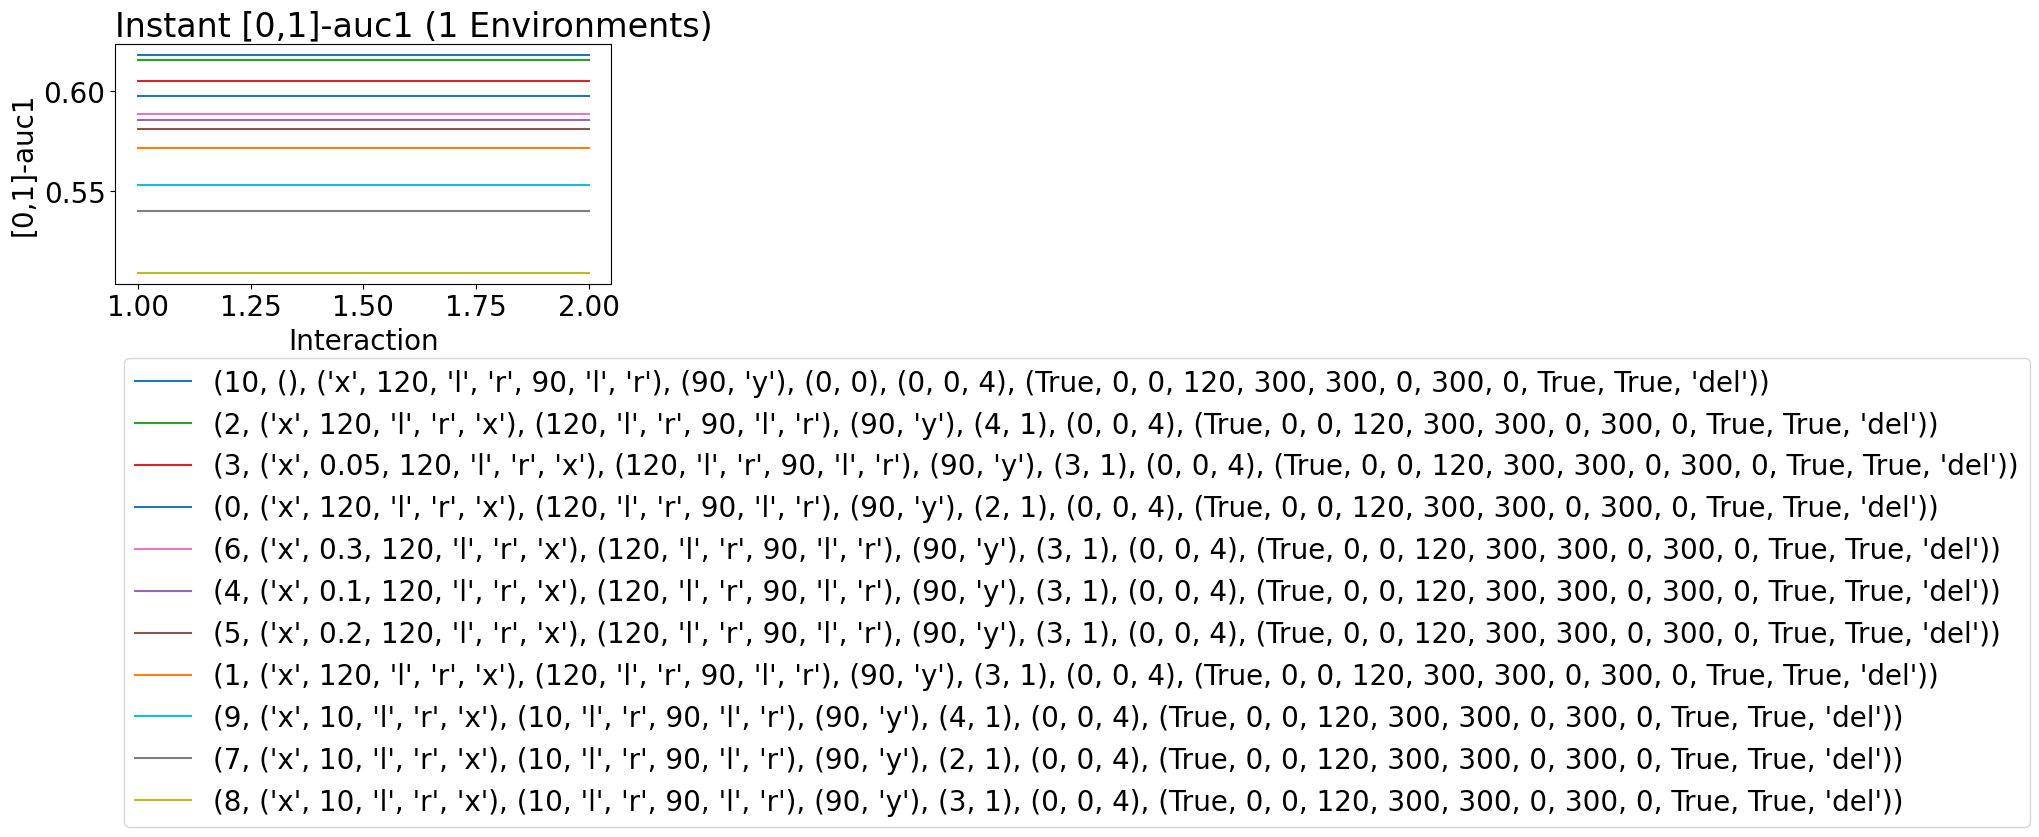

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None


    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))
        
        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, True, True, 'del'),[[0,1]], g, 1) for g in outer_gs ]

envs = env1
lrns = [ None ]
vals = [
    MyEvaluator(('x',120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 2, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',.05 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',.1 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',.2 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',.3 ,120,'l','r','x'), (120,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',10,'l','r','x'), (10,'l','r',90,'l','r'), (90,'y'), 2, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',10,'l','r','x'), (10,'l','r',90,'l','r'), (90,'y'), 3, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(('x',10,'l','r','x'), (10,'l','r',90,'l','r'), (90,'y'), 4, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator(()             , ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, [])
]

res = cb.Experiment(envs,lrns,vals).run(processes=20,quiet=True) #type: ignore
L = ['evaluator_id','s1','s2','s3','dae','ws','trn']
res.plot_learners('index','[0,1]-auc1',l=L,p=["g","rng"],span=1)

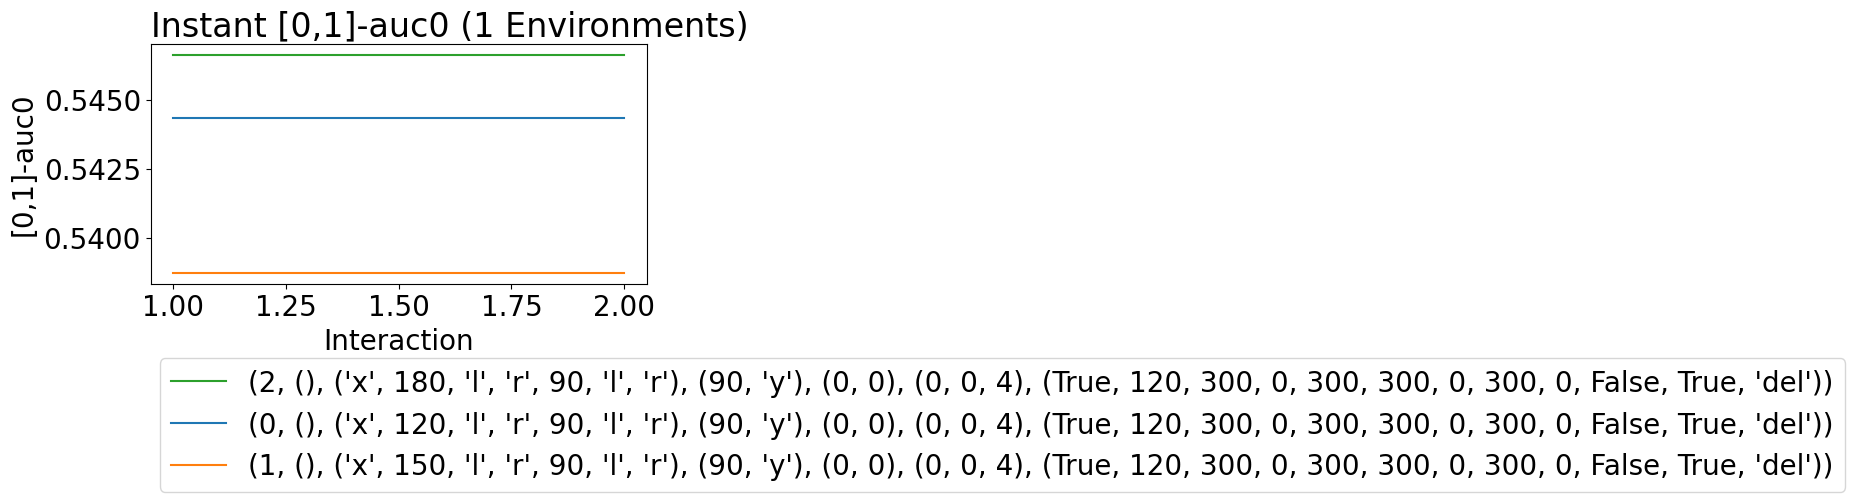

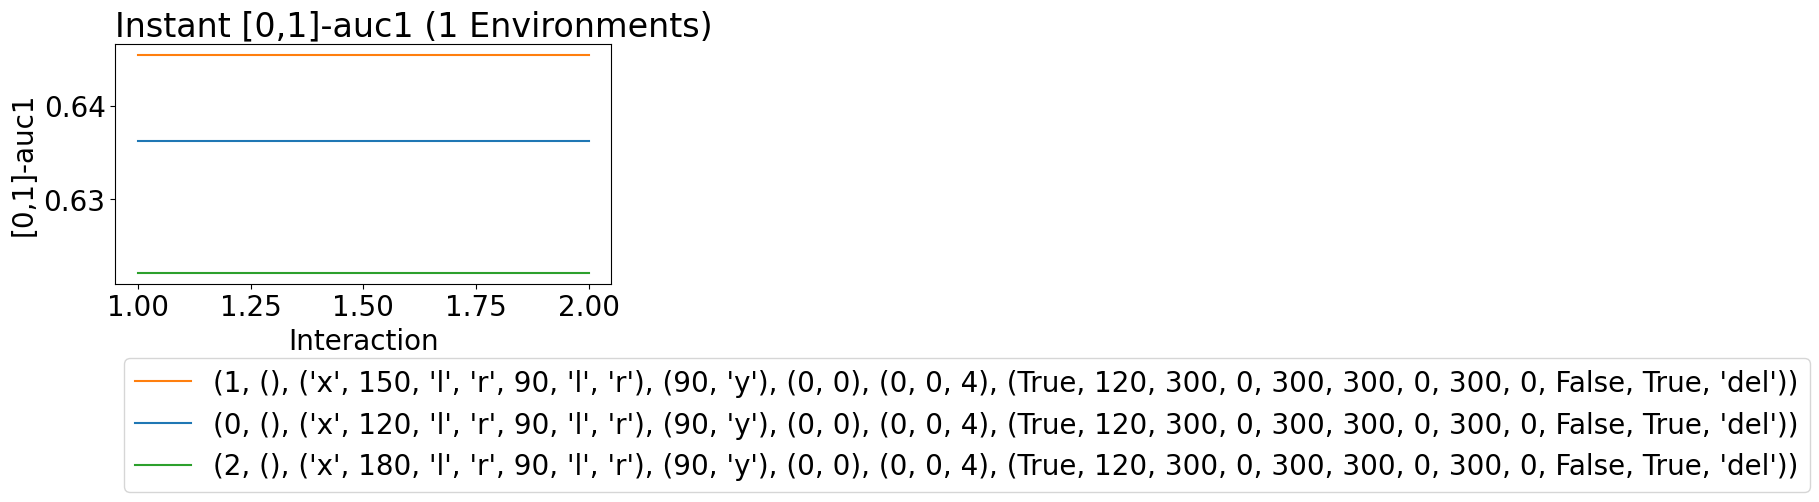

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))
        
        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, True, True, 'del'),[[0,1]], g, 1) for g in outer_gs ]

envs = [ env1 ]
lrns = [ None ]
vals = [
    MyEvaluator((), ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator((), ('x',150,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator((), ('x',180,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, [])
]

res = cb.Experiment(envs,lrns,vals).run(processes=20,quiet=True) #type: ignore
L = ['evaluator_id','s1','s2','s3','dae','ws','trn']
res.plot_learners('index','[0,1]-auc0',l=L,p=["rng"],span=1)
res.plot_learners('index','[0,1]-auc1',l=L,p=["rng"],span=1)

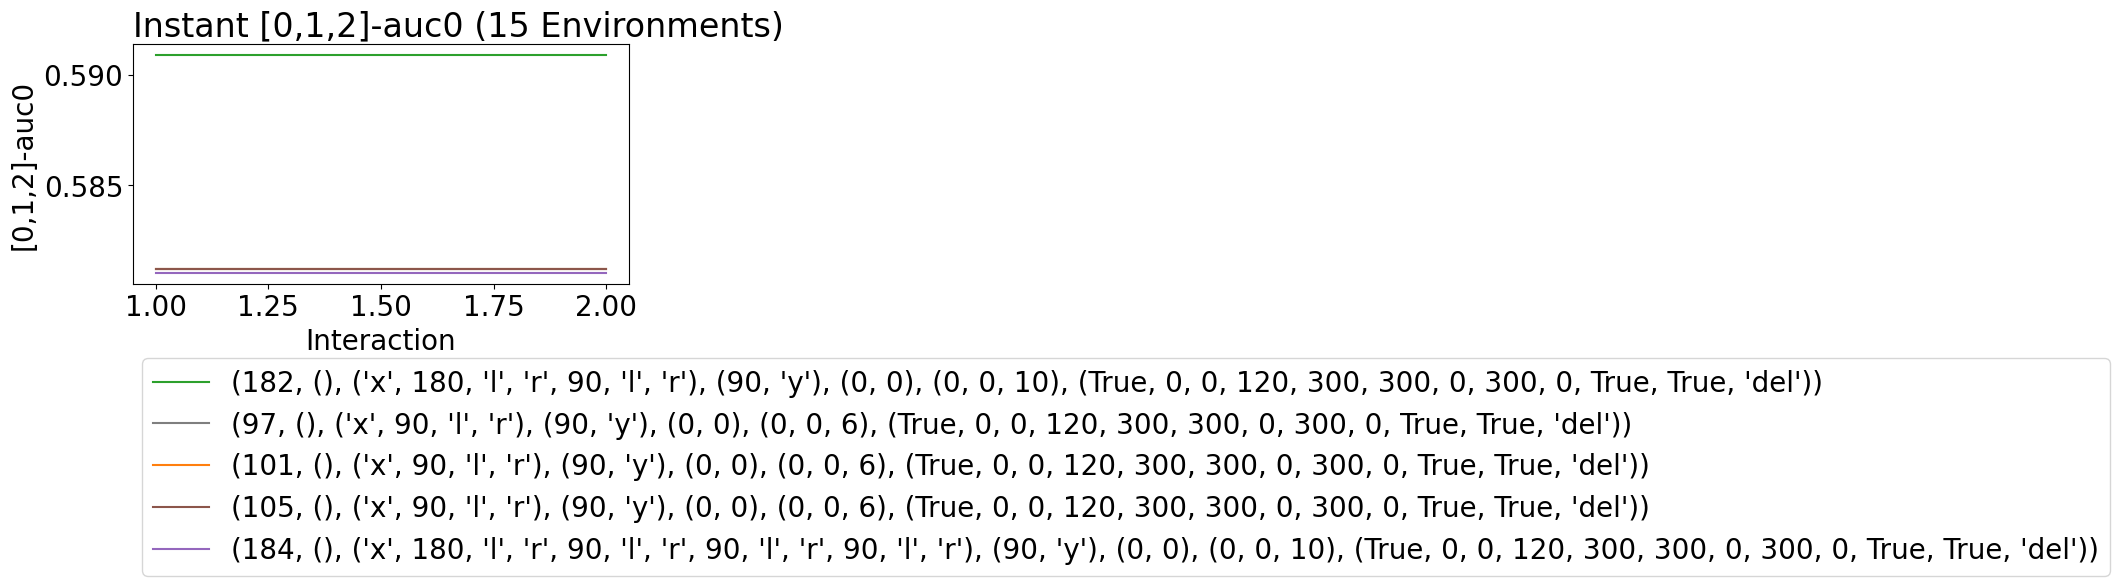

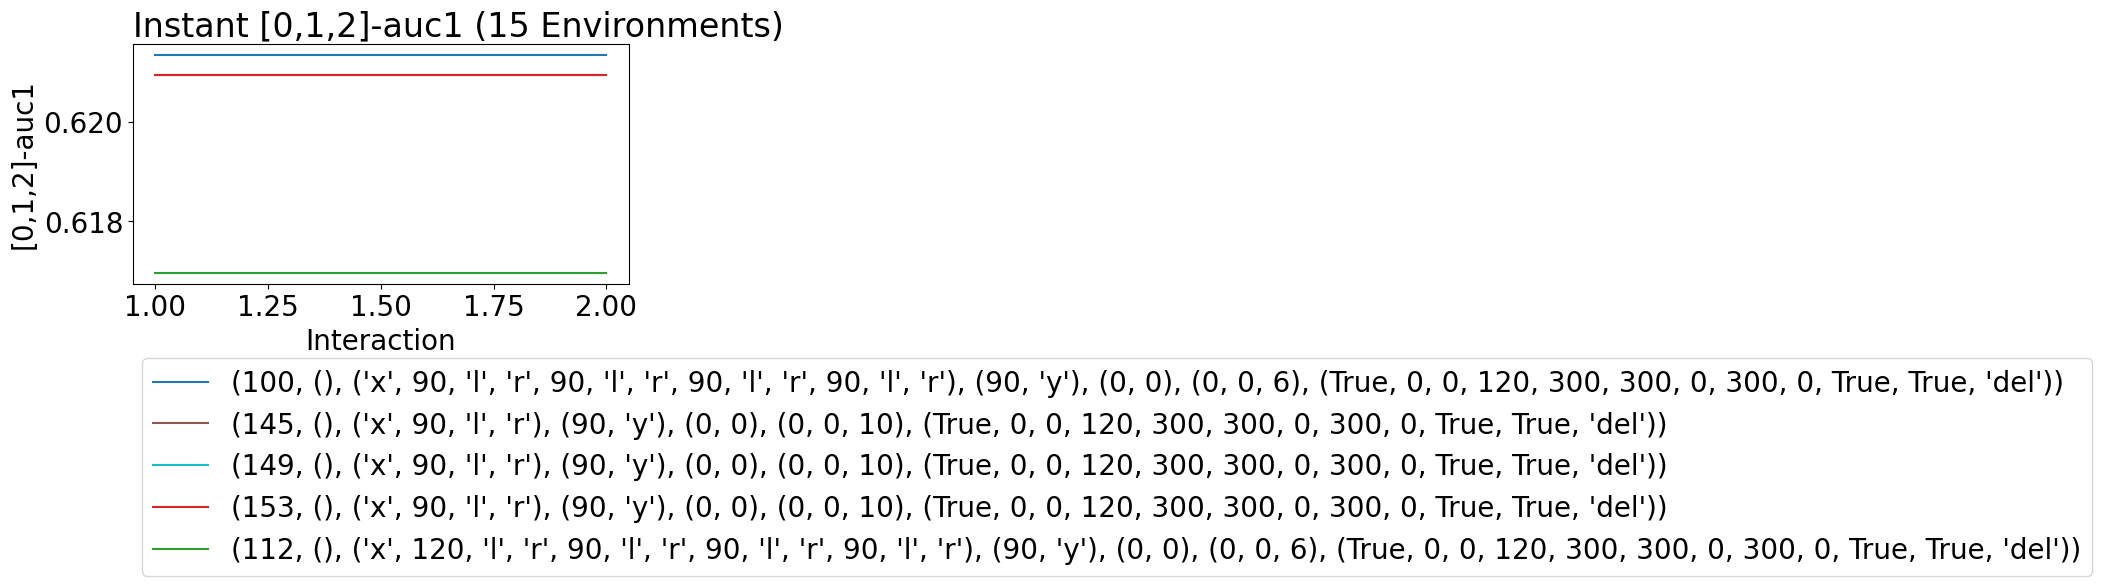

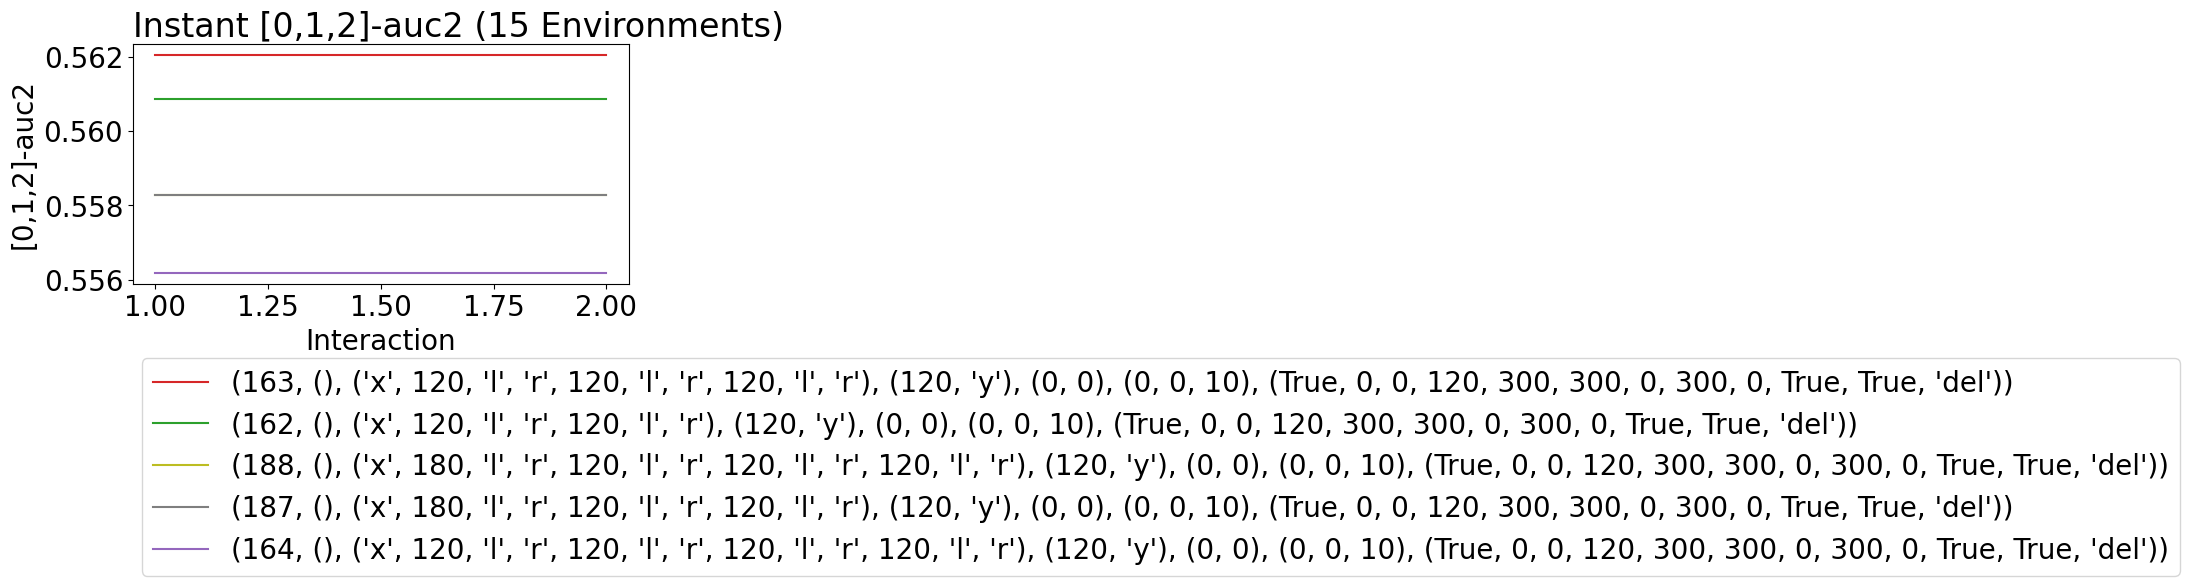

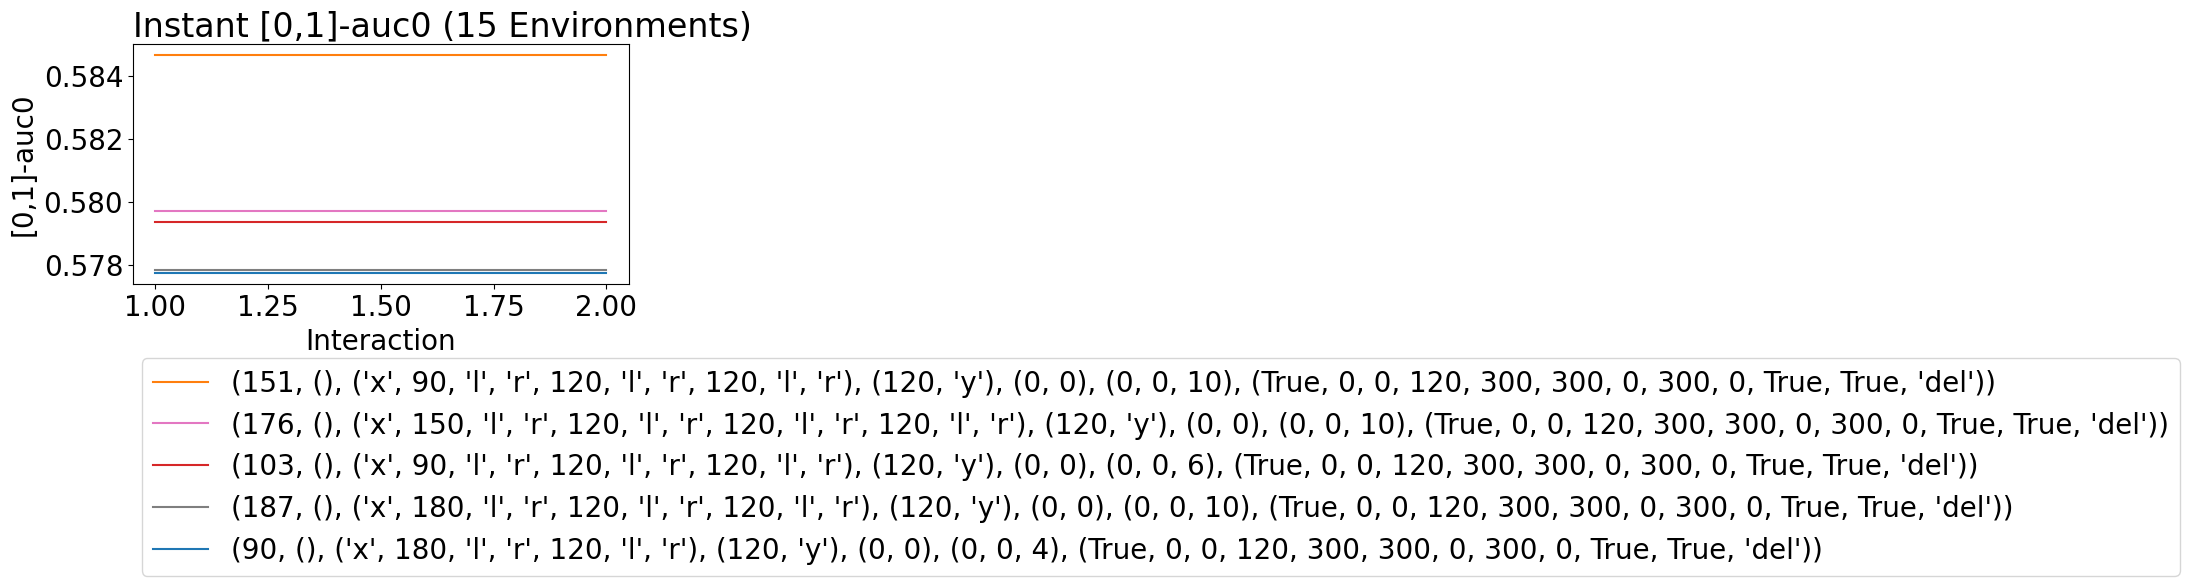

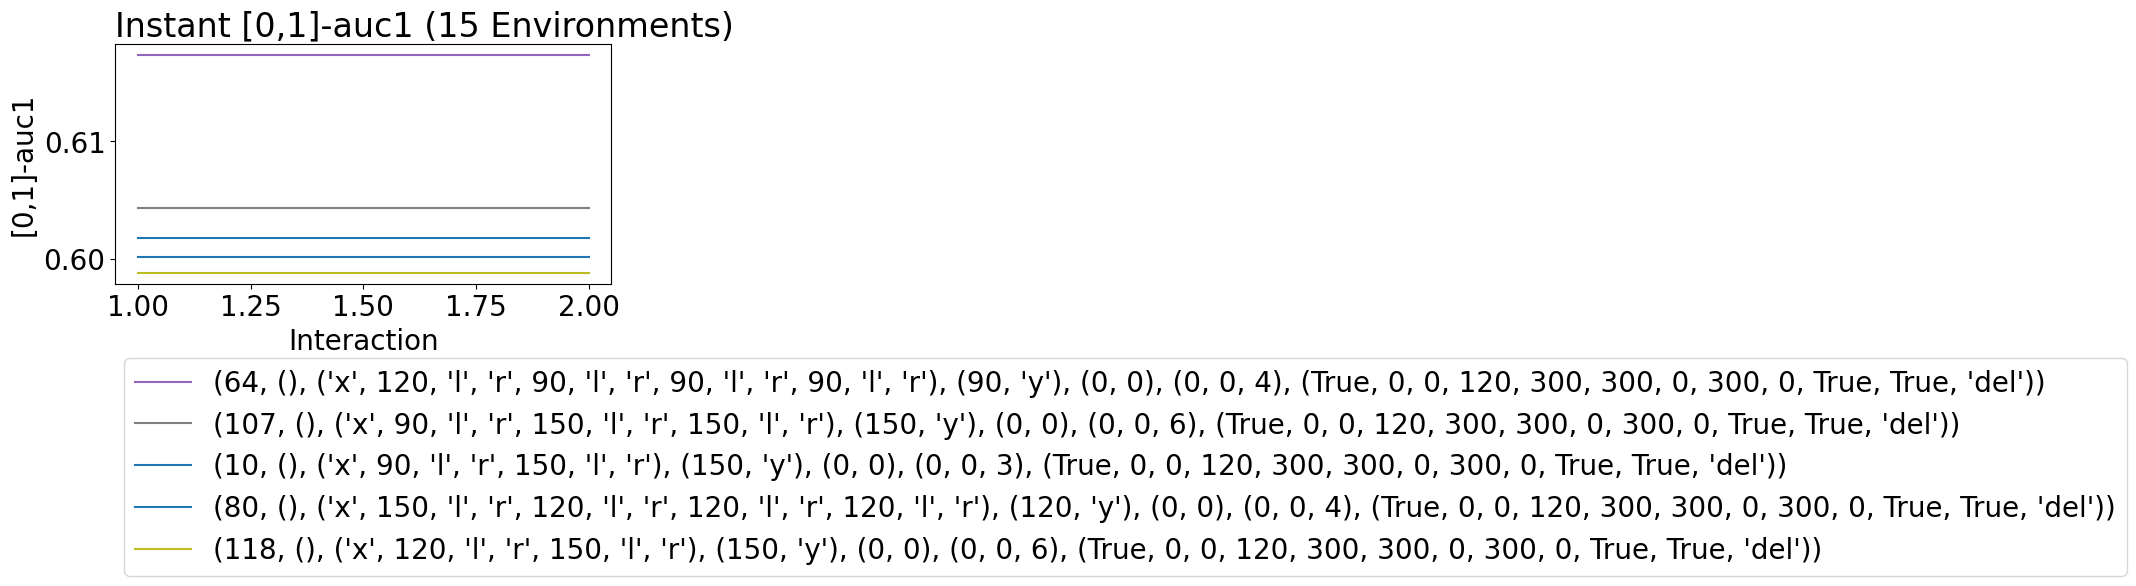

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G
        
        make = make_xyg1 if self.v == 1 else make_xyg2
        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, True, True, 'del'), [[0,1],[0,1,2]], g, 1) for g in outer_gs ]
env1 = [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, False, True, 'del'), [[0,1],[0,1,2]], g, 1) for g in outer_gs ]

envs = env1
lrns = [ None ]
vals = [MyEvaluator((), ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, [])]
for e,w,l2,d in product([3,4,6,10],[90,120,150,180],[90,120,150],[0,1,2,3]):
    vals.append(MyEvaluator((), ('x',w,'l','r',*[l2,'l','r']*d), (w if d == 0 else l2,'y'), 0, 0, 0, 0, e, 0, 0, 0, 0, 0, 1, []))

res = cb.Experiment(envs,lrns,vals).run(processes=38,quiet=True) #type: ignore
L = ['evaluator_id','s1','s2','s3','dae','ws','trn']
res.plot_learners('index','[0,1,2]-auc0',l=L,p=["rng","g"],span=1,top_n=5)
res.plot_learners('index','[0,1,2]-auc1',l=L,p=["rng","g"],span=1,top_n=5)
res.plot_learners('index','[0,1,2]-auc2',l=L,p=["rng","g"],span=1,top_n=5)
res.plot_learners('index','[0,1]-auc0',l=L,p=["rng","g"],span=1,top_n=5)
res.plot_learners('index','[0,1]-auc1',l=L,p=["rng","g"],span=1,top_n=5)


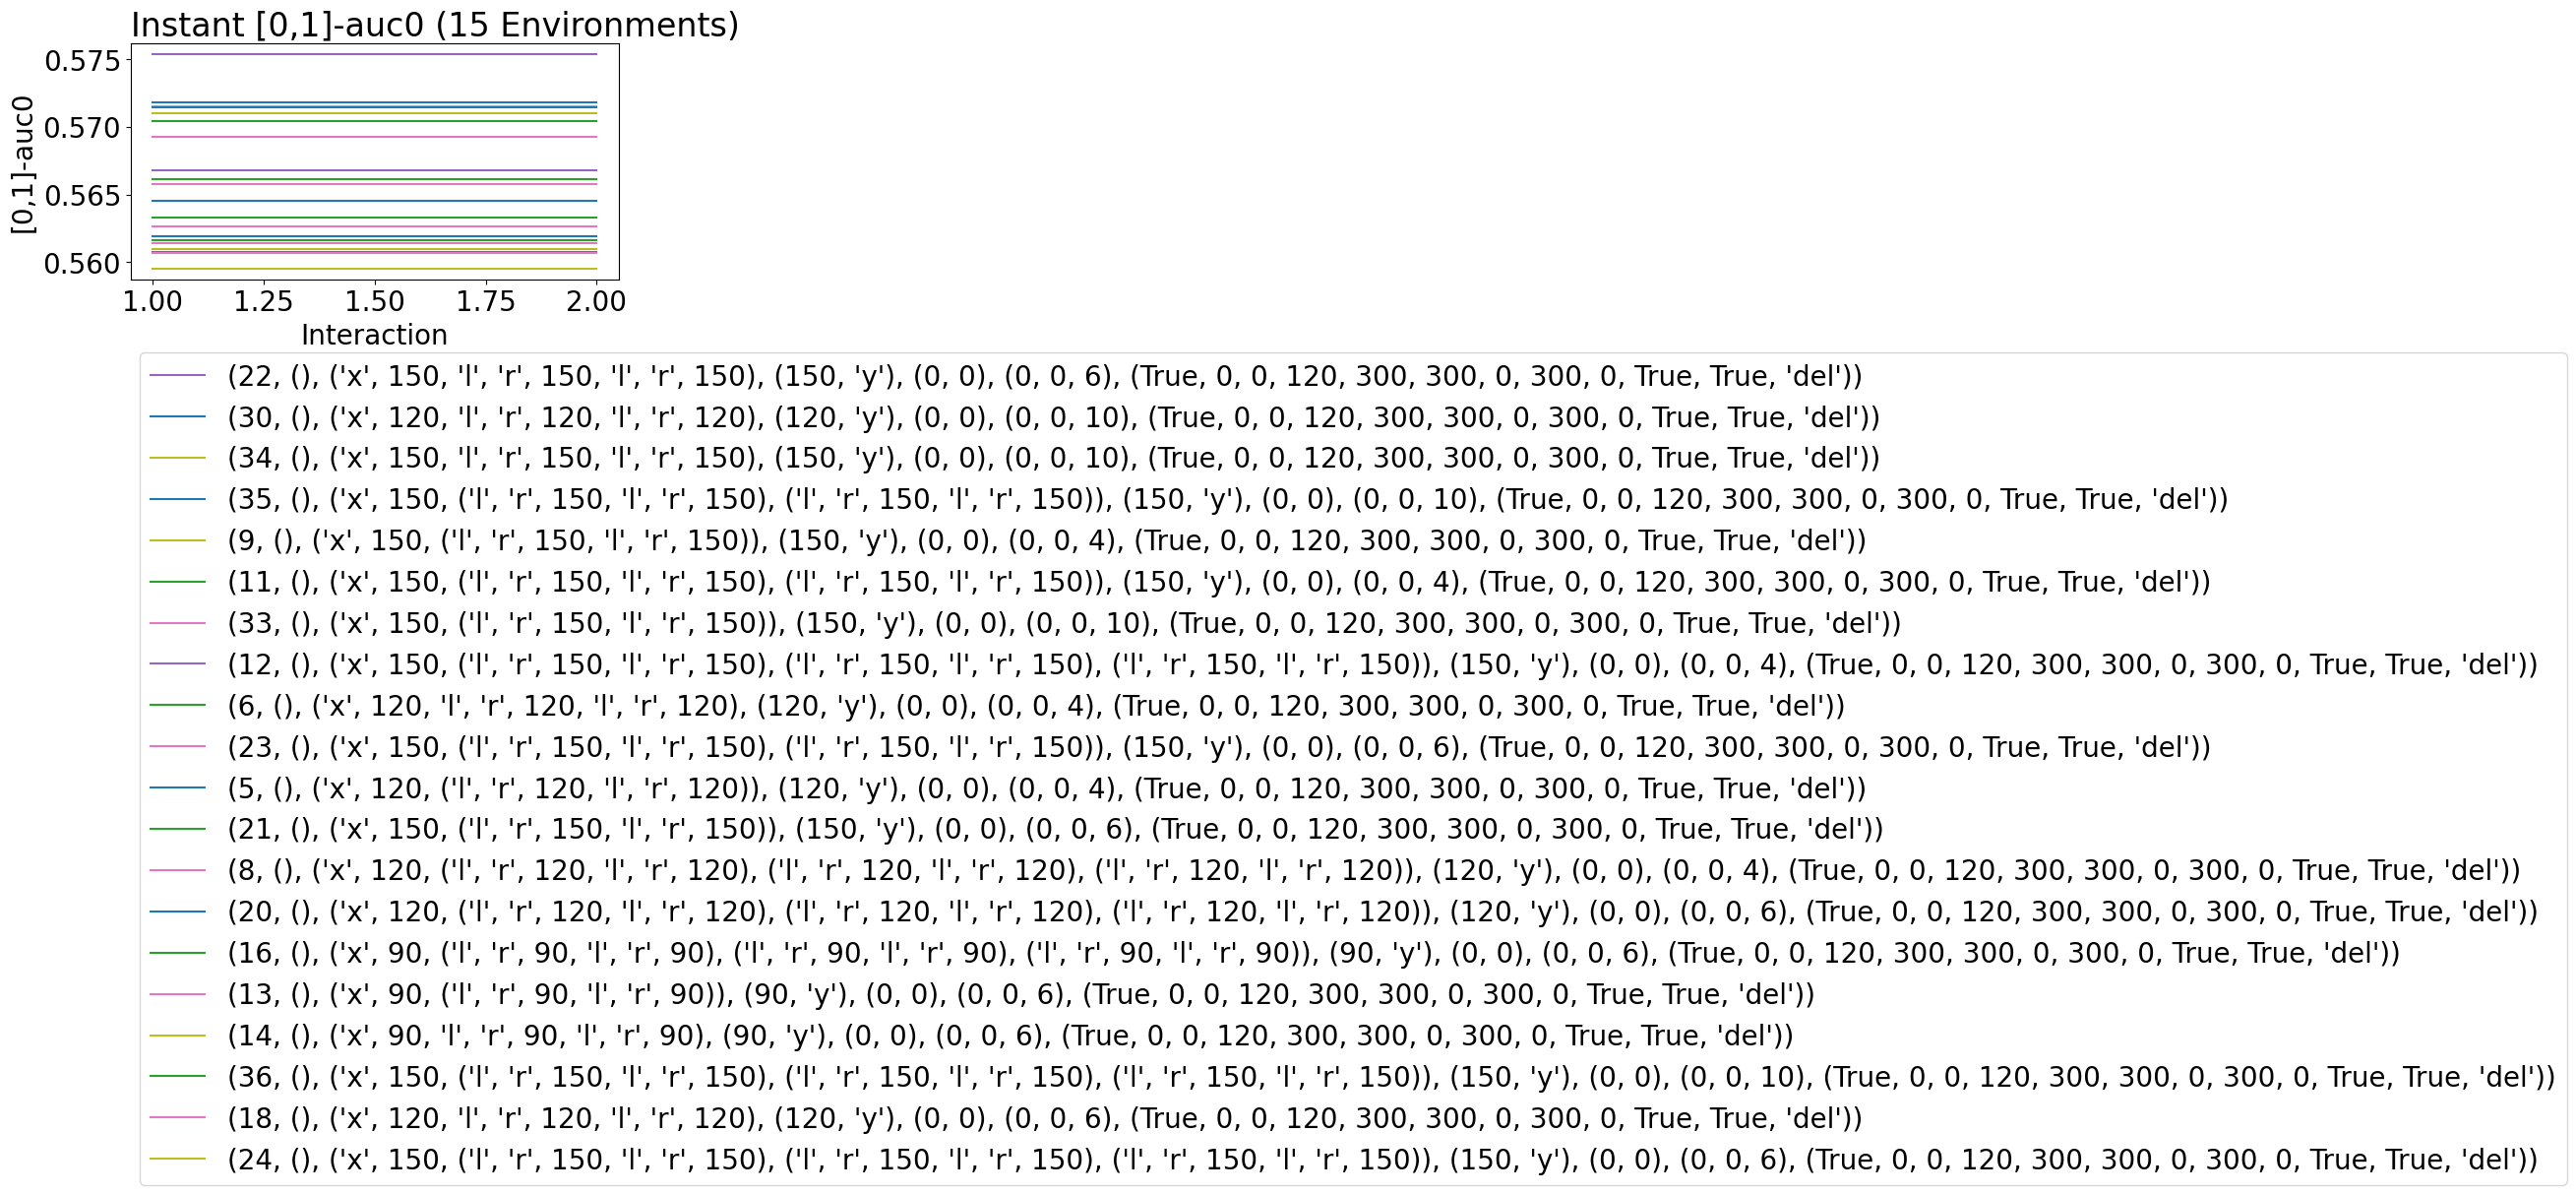

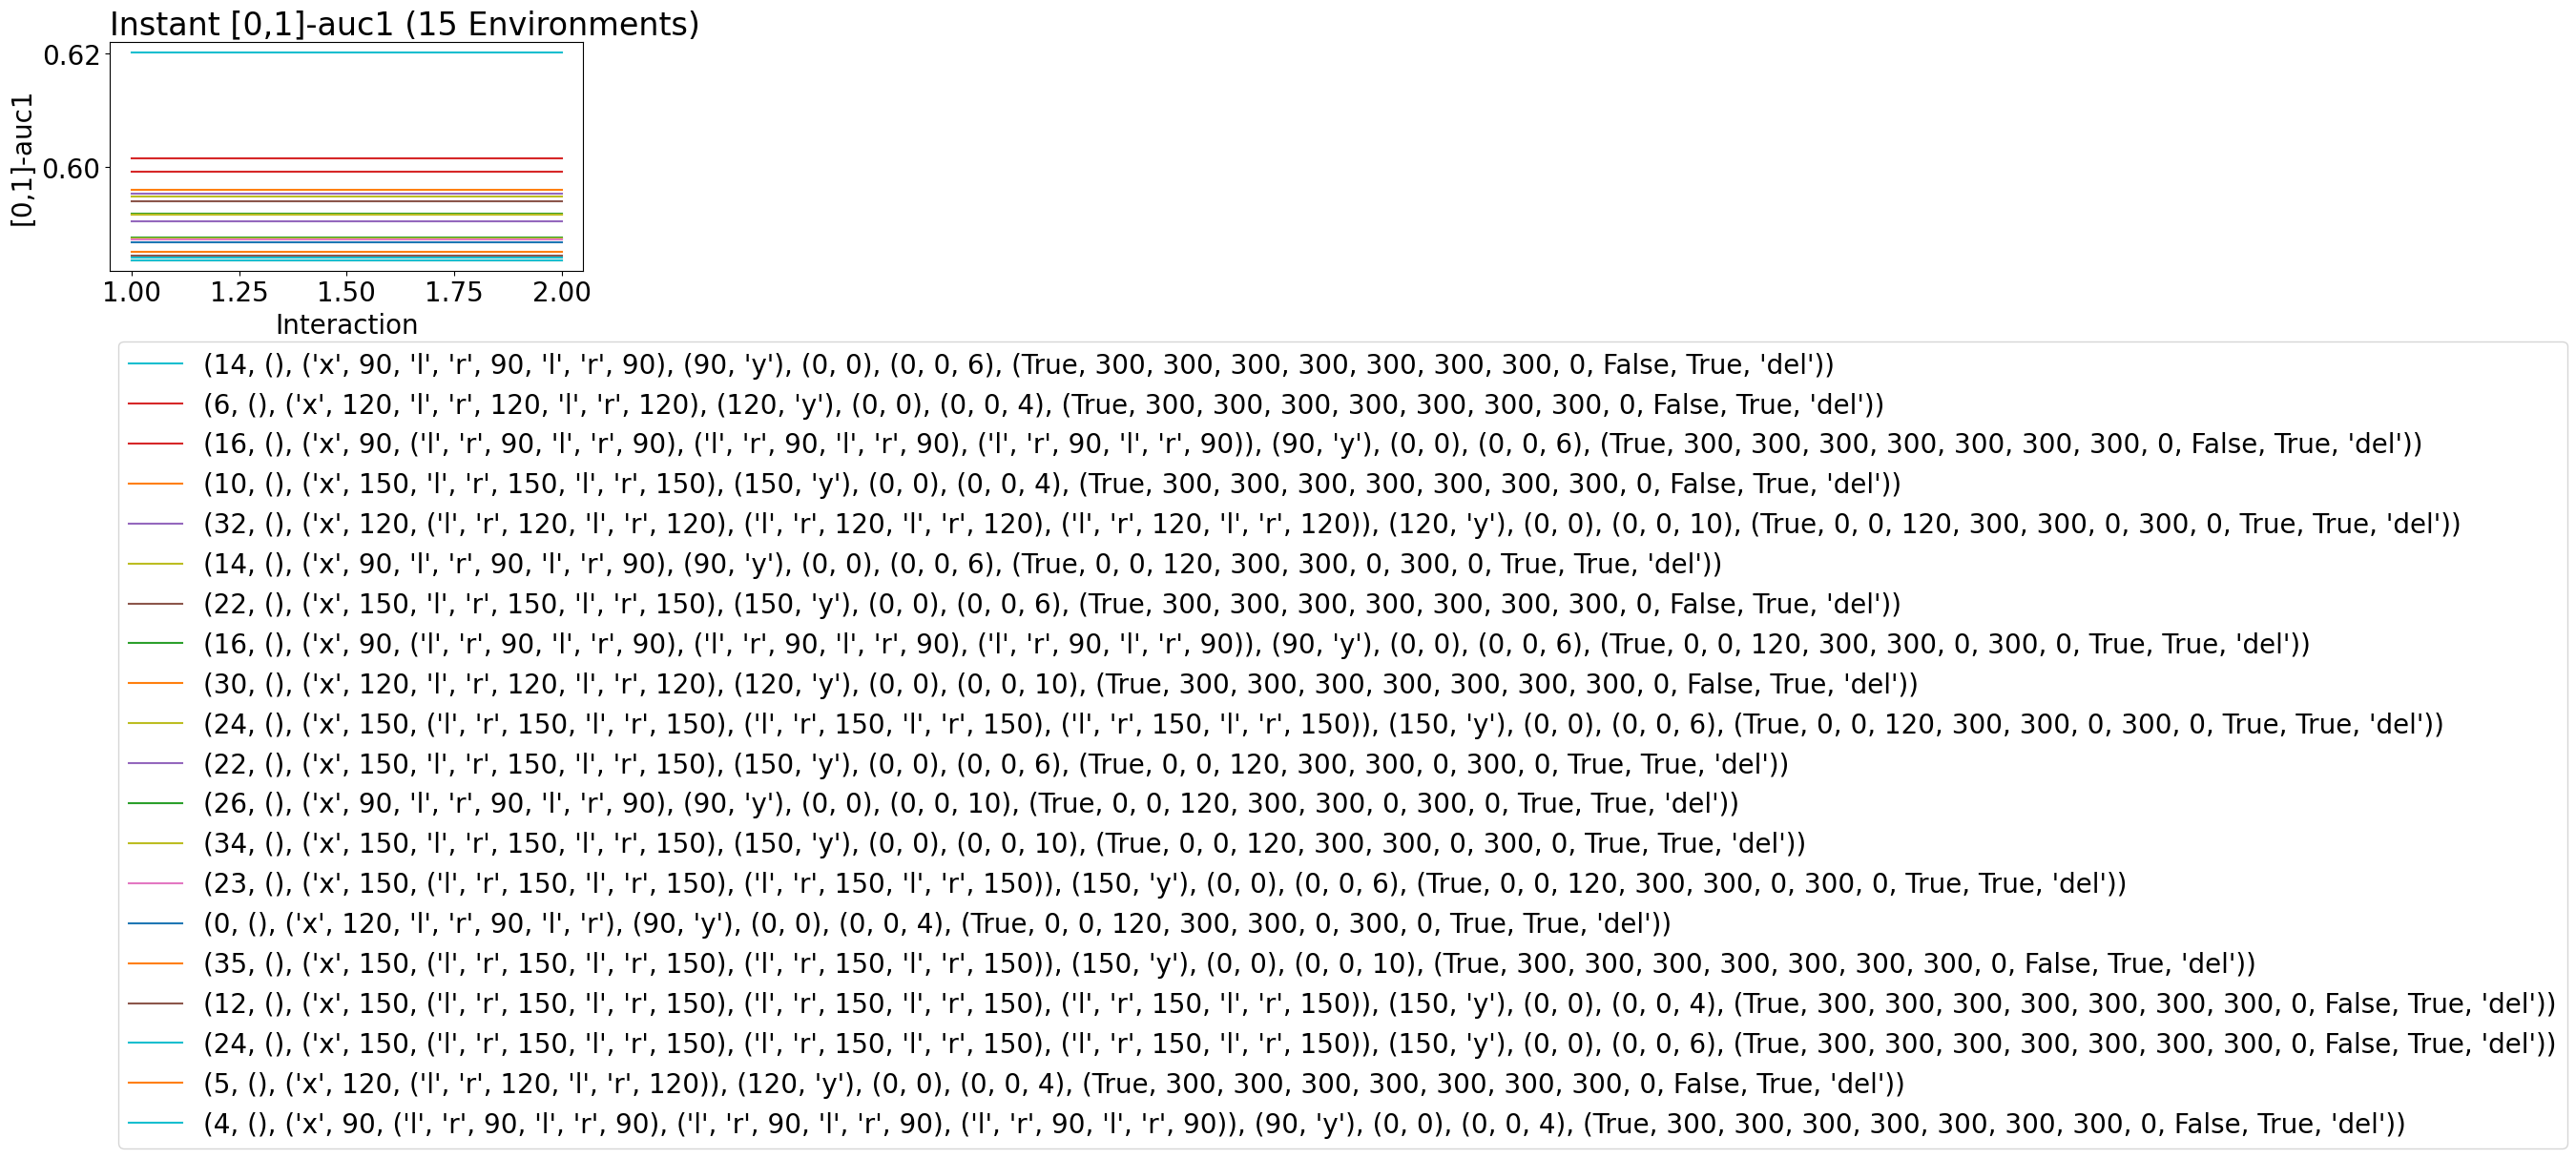

In [ ]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, v=2):
        self.params = {'rng': rng, 'trn':a, 'l':L, 'v':v, 'g':g }
        self.X = None
        self.Y = None
        self.G = None
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_data(self):
        import torch
        import itertools as it

        if self.X is not None: return self.X,self.Y,self.G

        make = make_xyg1 if self.v == 1 else make_xyg2

        X,Y,G = zip(*map(make, work_items(*self.a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()

        self.X,self.Y,self.G = X,Y,G

        if X.shape[0] == 0: return

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score

env1 = [ MyEnvironment((True, 0, 0, 300, 300, 300, 0, 300, 0, True, True, 'del'), [[0,1],[0,1,2]], g, 1) for g in outer_gs ]

envs = env1 + env2
lrns = [ None ]
vals = [MyEvaluator((), ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, [])]
for e,w,d in product([4,6,10],[90,120,150],[1,2,3]):
    if d != 1: vals.append(MyEvaluator((), ('x',w, *[ ['l', 'r', w, 'l', 'r', w] ] *d ), (w,'y'), 0, 0, 0, 0, e, 0, 0, 0, 0, 0, 1, []))
    vals.append(MyEvaluator((), ('x',w,'l','r',w,'l','r',w), (w,'y'), 0, 0, 0, 0, e, 0, 0, 0, 0, 0, 1, []))

res = cb.Experiment(envs,lrns,vals).run(processes=38,quiet=True) #type: ignore
L = ['evaluator_id','s1','s2','s3','dae','ws','trn']
#res.plot_learners('index','[0,1,2]-auc0',l=L,p=["rng","g"],span=1,top_n=5)
#res.plot_learners('index','[0,1,2]-auc1',l=L,p=["rng","g"],span=1,top_n=5)
#res.plot_learners('index','[0,1,2]-auc2',l=L,p=["rng","g"],span=1,top_n=5)
res.plot_learners('index','[0,1]-auc0',l=L,p=["rng","g"],span=1,top_n=20)
res.plot_learners('index','[0,1]-auc1',l=L,p=["rng","g"],span=1,top_n=20)


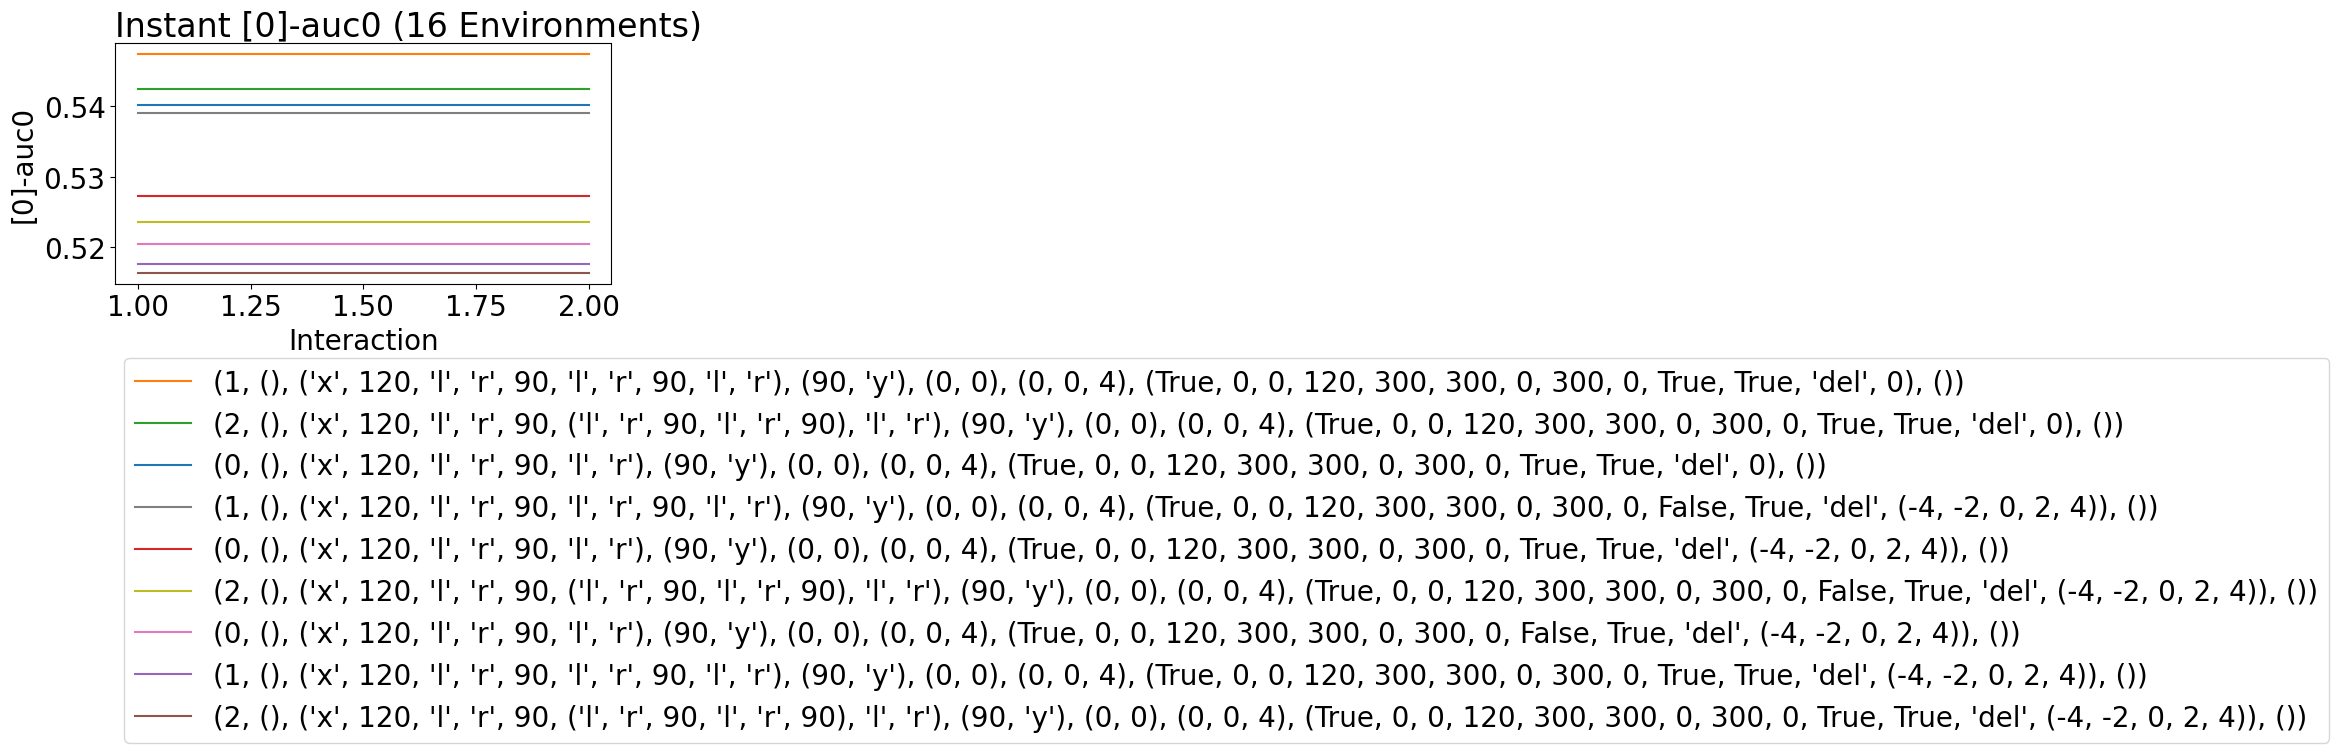

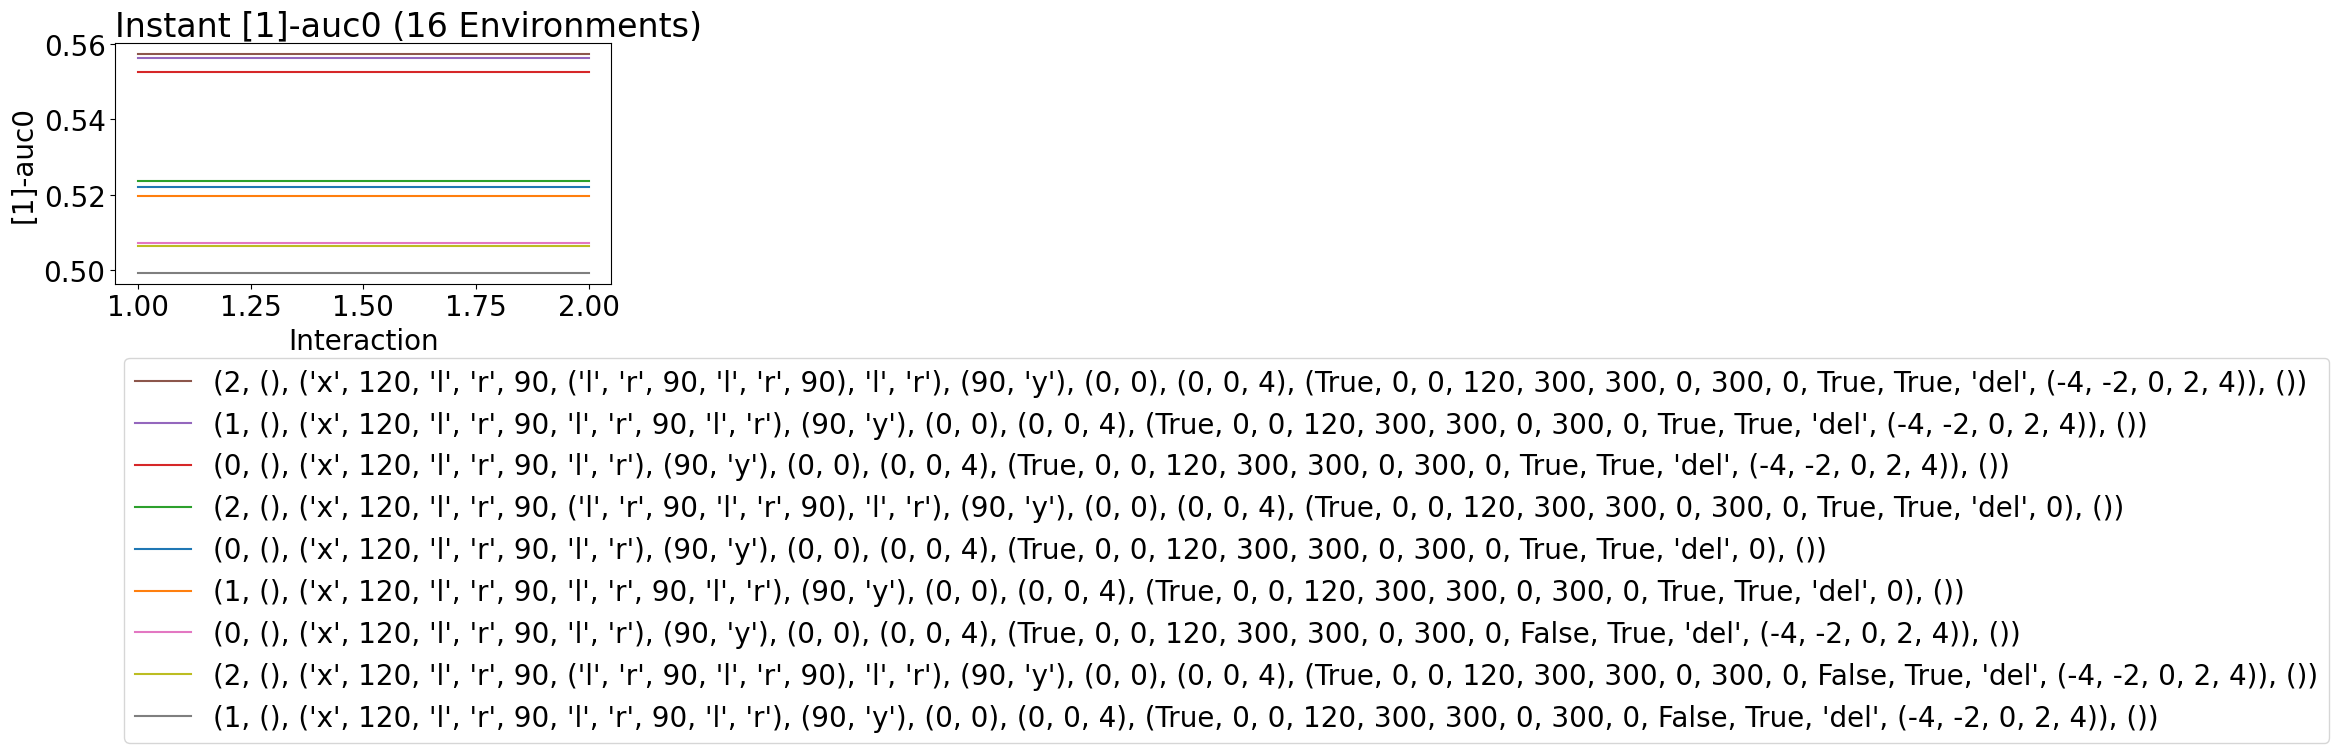

In [226]:
class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)
        
    class ForceOneModule(torch.nn.Module):
        def forward(self,X):
            return torch.ones(size=(X.shape[0],1)).float()

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if spec == '1':
            return FeedForward.ForceOneModule(), 1
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception(f"Bad Layer: {spec}")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, a, L, g, rng, tst=[0],v=2):
        self.params = {'rng': rng, 'l':L, 'v':v, 'g':g, 'trn': a, 'tst':tst }
        self.X = None
        self.Y = None
        self.G = None
        self.tst = tst
        self.a = list(a)
        self.L = L
        self.g = g
        self.v = v
        self.a[7] = [a[7],2,1,10] if a[7] else None

    def get_trn_tst(self,G):
        is_tst = sum(G == i for i in self.g).bool() #type: ignore
        return ~is_tst, is_tst

    def get(self,v,a):
        import itertools as it
        import torch

        make = make_xyg1 if v == 1 else make_xyg2
        X,Y,G = zip(*map(make, work_items(*a)))

        X = torch.tensor(list(it.chain.from_iterable(X))).float()
        Y = torch.tensor(list(it.chain.from_iterable(Y))).float()
        G = torch.tensor(list(it.chain.from_iterable(G))).int()
        
        if X.shape[0] == 0: return X,Y,G

        any_na = torch.isnan(Y[:,[0,1]]).any(dim=1)
        X = X[~any_na]
        Y = Y[~any_na].float()
        G = G[~any_na]

        return X,Y,G

    def get_data(self):
        import torch
        
        if self.X is not None: return self.X,self.Y,self.G

        trn_a = self.a
        tst_a = list(trn_a)
        tst_a[12] = self.tst

        X,Y,G = self.get(self.v,trn_a)

        if X.shape[0] == 0:
            self.X,self.Y,self.G=X,Y,G
            return X,Y,G

        is_trn = self.get_trn_tst(G)[0]
        trn_X,trn_Y,trn_G = X[is_trn],Y[is_trn],G[is_trn]

        X,Y,G = self.get(self.v,tst_a)

        assert X.shape[0] != 0

        is_tst = self.get_trn_tst(G)[1]
        tst_X,tst_Y,tst_G = X[is_tst],Y[is_tst],G[is_tst]

        X = torch.vstack([trn_X,tst_X])
        Y = torch.vstack([trn_Y,tst_Y])
        G = torch.hstack([trn_G,tst_G])

        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(X)))

        self.X,self.Y,self.G = X[rng_indexes],Y[rng_indexes],G[rng_indexes]

        return self.X,self.Y,self.G

class MyEvaluator:
    def __init__(self, s1, s2, s3, dae_steps, dae_dropn, ws_steps0, ws_drop0, ws_steps1, pers_lrn_cnt, pers_mem_cnt, pers_mem_rpt, pers_mem_rcl, pers_rank, n_models, weighted):

        self.s1  = s1  #dae sep-sl
        self.s2  = s2  #sep-sl
        self.s3  = s3  #one-sl pers

        self.dae_steps = dae_steps
        self.dae_dropn = dae_dropn

        self.ws_steps0 = ws_steps0
        self.ws_drop0  = ws_drop0
        self.ws_steps1 = ws_steps1

        self.pers_lrn_cnt = pers_lrn_cnt
        self.pers_mem_cnt = pers_mem_cnt
        self.pers_mem_rpt = pers_mem_rpt
        self.pers_mem_rcl = pers_mem_rcl
        self.pers_rank    = pers_rank

        self.n_models = n_models
        self.weighted = weighted

        self.params = { 's1': s1, 's2':s2, 's3':s3, 'dae': (dae_steps,dae_dropn), 'ws': (ws_steps0,ws_drop0,ws_steps1), 'pers': (pers_lrn_cnt,pers_mem_cnt,pers_mem_rpt,pers_mem_rcl,pers_rank), 'n_models': n_models, 'weighted': weighted }

    def evaluate(self, env, lrn):
        from numpy import nanmean
        from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score
        from collections import Counter

        X,Y,G = env.get_data()
        if len(X) == 0: return
    
        torch.set_num_threads(1)

        def make_weights(G):
            W = torch.zeros((len(G),1))
            weights = Counter(G.tolist())
            for g,w in weights.items():
                W[G==g] = 1/w
            return (W / W.max())
        
        def get_trn_tst(G,g):
            is_tst = sum(G == i for i in g).bool() #type: ignore            
            return ~is_tst, is_tst

        def get_scores(X,Y,G,g):

            torch.manual_seed(env.params['rng'])

            is_trn, is_tst = get_trn_tst(G,g)
            trn_X, trn_Y, trn_G = X[is_trn], Y[is_trn], G[is_trn]
            tst_X, tst_Y, tst_G = X[is_tst], Y[is_tst], G[is_tst]

            n_feats = X.shape[1]
            n_persons = len(set(trn_G.tolist()))
            n_tasks = Y.shape[1]

            _s1 = [n_feats if f == 'x' else f if f != '-x' else n_feats*n_persons for f in self.s1]
            _s2 = [n_feats if f == 'x' else f                                     for f in self.s2]
            _s3 = [n_feats if f == 'x' else f                                     for f in self.s3]

            _s1 = [n_tasks if f == 'y' else f for f in _s1]
            _s2 = [n_tasks if f == 'y' else f for f in _s2]
            _s3 = [n_tasks if f == 'y' else f for f in _s3]

            if _s2 and _s2[-1] == -1: _s2 = (*(_s2)[:-1], n_persons*n_tasks)
            if _s3 and _s3[ 0] == -1: _s3 = (n_persons*n_tasks, *(_s3)[1:])

            mods_opts = []
            opts = []

            for _ in range(self.n_models):
                s1 = FeedForward(_s1)
                s2 = FeedForward(_s2)
                s3 = FeedForward(_s3)

                s1_children = list(s1.children())
                s2_children = list(s2.children())

                sa = torch.nn.Sequential(*s1_children[len(s1_children)-self.dae_dropn:])
                s1 = torch.nn.Sequential(*s1_children[:len(s1_children)-self.dae_dropn])

                sb = torch.nn.Sequential(*s2_children[len(s2_children)-self.ws_drop0:])
                s2 = torch.nn.Sequential(*s2_children[:len(s2_children)-self.ws_drop0])

                s1opt = COCOB(s1.parameters()) if list(s1.parameters()) else None
                saopt = COCOB(sa.parameters()) if list(sa.parameters()) else None
                s2opt = COCOB(s2.parameters()) if list(s2.parameters()) else None
                sbopt = COCOB(sb.parameters()) if list(sb.parameters()) else None
                s3opt = COCOB(s3.parameters()) if list(s3.parameters()) else None

                mods = [s1,sa,s2,sb,s3]
                opts = [s1opt,saopt,s2opt,sbopt,s3opt]
                mods_opts.append([mods,opts])

            for mods,_ in mods_opts:
                for m in mods: m.train()

            for mods,opts in mods_opts:
                [s1,sa,s2,sb,s3] = mods
                [s1opt,saopt,s2opt,sbopt,s3opt] = opts

                if _s1 and self.dae_steps:
                    opts = list(filter(None,[s1opt,saopt]))
                    X,G,W = trn_X,trn_G,make_weights(trn_G)

                    if _s1[-1] != n_feats*n_persons:
                        Z = X
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_feats + torch.arange(n_feats).unsqueeze(0)
                        R = torch.arange(len(X)).unsqueeze(1)
                        Z = torch.full((len(X),len(i)*n_feats), float('nan'))
                        Z[R,I] = X

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.L1Loss()
                    for _ in range(self.dae_steps):
                        for (_X,_z,_w) in torch_loader:
                            for o in opts: o.zero_grad()
                            loss(sa(s1(_X.nan_to_num()))[~_z.isnan()],_z[~_z.isnan()]).backward()                        
                            for o in opts: o.step()

                if self.ws_steps0:
                    opts = list(filter(None,[s1opt,s2opt,sbopt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    if _s2[-1] != n_tasks*n_persons:
                        Z = Y
                    else:
                        i = defaultdict(lambda c= count(0):next(c))
                        I = torch.tensor([[i[g]] for g in G.tolist()]) * n_tasks + torch.arange(n_tasks).unsqueeze(0)
                        R = torch.arange(len(Y)).unsqueeze(1)
                        Z = torch.full((len(G),len(i)*n_tasks), float('nan'))
                        Z[R,I] = Y

                    torch_dataset = torch.utils.data.TensorDataset(X,Z,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    for _ in range(self.ws_steps0):
                        for _X,_z,_w in torch_loader:
                            for o in opts: o.zero_grad()                        
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w.squeeze() if 2 in self.weighted else None)
                            loss(sb(s2(s1(_X.nan_to_num())))[~_z.isnan()],_z[~_z.isnan()]).backward()
                            for o in opts: o.step()

                if self.ws_steps1:
                    opts = list(filter(None,[s3opt] if self.ws_steps0 else [s1opt,s2opt,s3opt]))
                    for o in opts: o.zero_grad()

                    X, Y, G, W = trn_X,trn_Y,trn_G,make_weights(trn_G)

                    torch_dataset = torch.utils.data.TensorDataset(X,Y,W)
                    torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=8,drop_last=True,shuffle=True)

                    loss = torch.nn.BCEWithLogitsLoss()
                    for _ in range(self.ws_steps1):
                        for _X,_y,_w in torch_loader:
                            for o in opts: o.zero_grad()
                            loss = torch.nn.BCEWithLogitsLoss(weight=_w if 3 in self.weighted else None)
                            loss(s3(s2(s1(_X.nan_to_num()))),_y).backward()
                            for o in opts: o.step()

            for mods,_ in mods_opts:
                for m in mods: m.eval()

            def predict(X):
                preds = torch.tensor(0)
                for mods,_ in mods_opts:
                    [s1,_,s2,_,s3] = mods
                    if s3: preds = preds + torch.sigmoid(s3(s2(s1(X.nan_to_num()))))
                return preds/len(mods_opts)

            def score(X,Y):
                out = defaultdict(lambda:float("nan"))            
                with torch.no_grad():
                    probs = predict(X)
                    preds = (probs>=.5).float()
                    for i in range(n_tasks):

                        if len(set(Y[:,i].tolist())) == 1: continue

                        tp = ((preds[:,i]==1) & (Y[:,i]==1)).float().mean().item()
                        tn = ((preds[:,i]==0) & (Y[:,i]==0)).float().mean().item()
                        fp = ((preds[:,i]==1) & (Y[:,i]==0)).float().mean().item()
                        fn = ((preds[:,i]==0) & (Y[:,i]==1)).float().mean().item()

                        out[f"auc{i}"] = roc_auc_score(Y[:,i],probs[:,i])
                        out[f"bal{i}"] = balanced_accuracy_score(Y[:,i],preds[:,i])
                        out[f"sen{i}"] = tp/(tp+fn)
                        out[f"spe{i}"] = tn/(tn+fp)

                        for j in [0,1]:
                            out[f"f1{j}{i}" ] = f1_score(Y[:,i],preds[:,i],pos_label=j)
                            out[f"pre{j}{i}"] = precision_score(Y[:,i],preds[:,i],pos_label=j,zero_division=0)
                            out[f"rec{j}{i}"] = recall_score(Y[:,i],preds[:,i],pos_label=j)

                        out[f"f1m{i}"] = f1_score(Y[:,i],preds[:,i],average='macro')
                        out[f"f1w{i}"] = f1_score(Y[:,i],preds[:,i],average='weighted')

                    return out

            X, Y, G = tst_X, tst_Y, tst_G

            return [score(X[G==pid],Y[G==pid]) for pid in g]

        score = {}
        for l in env.L:
            scores = get_scores(X,Y[:,l],G,env.g)            
            for k in set().union(*scores):
                score[f"g{l}-{k}".replace(", ",",")] = [s[k] for s in scores]
                score[f"{l}-{k}".replace(", ",",")]  = nanmean([s[k] for s in scores])

        yield score
        yield score



tst = [-4,-2,0,2,4]
trn = tst


envs = []
envs += [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, True, True, 'del',   0), [[0],[1]], g, 1, tst) for g in outer_gs ]
envs += [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, True, True, 'del', trn), [[0],[1]], g, 1, tst) for g in outer_gs ]
envs += [ MyEnvironment((True, 0, 0, 120, 300, 300, 0, 300, 0, False, True, 'del', trn), [[0],[1]], g, 1, tst) for g in outer_gs ]

lrns = [ None ]
vals = [
    MyEvaluator((), ('x',120,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0,  4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator((), ('x',120,'l','r',90,'l','r',90,'l','r'), (90,'y'), 0, 0, 0, 0,  4, 0, 0, 0, 0, 0, 1, []),
    MyEvaluator((), ('x',120,'l','r',90,['l','r',90,'l','r',90],'l','r'), (90,'y'), 0, 0, 0, 0,  4, 0, 0, 0, 0, 0, 1, []),
]

res = cb.Experiment(envs,lrns,vals).run(processes=38,quiet=True) #type: ignore
L = ['evaluator_id','s1','s2','s3','dae','ws','trn','weighted']
#res.plot_learners('index','[0,1,2]-auc0',l=L,p=["rng","g"],span=1,top_n=2)
#res.plot_learners('index','[0,1,2]-auc1',l=L,p=["rng","g"],span=1,top_n=2)
#res.plot_learners('index','[0,1,2]-auc2',l=L,p=["rng","g"],span=1,top_n=2)
#res.plot_learners('index','[0,1]-auc0'  ,l=L,p=["rng","g"],span=1,top_n=2)
#res.plot_learners('index','[0,1]-auc1'  ,l=L,p=["rng","g"],span=1,top_n=2)
res.plot_learners('index','[0]-auc0'    ,l=L,p=["rng","g"],span=1)
res.plot_learners('index','[1]-auc0'    ,l=L,p=["rng","g"],span=1)


In [190]:
(envs0[0].get_data()[0].nan_to_num(0) - envs3[0].get_data()[0].nan_to_num(0)).abs().max()

tensor(3.5390)

In [197]:
envs0[0].get_data()[0][:10,6:]

tensor([[-0.6466,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         -0.2803,  2.9167,  0.9524,  3.5000,  2.6667,  2.1000,  0.0000],
        [-0.6466,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         -0.2803,  2.5833,  0.9048,  4.9444,  3.3333,  1.9000,  0.5000],
        [ 0.8817,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.7007,  2.5000,  0.3333,  3.9444,  2.4722,  1.5500,  0.0000],
        [ 3.1741,  0.0000,  1.0000,  1.0000,     nan,     nan,     nan,     nan,
          0.7007,  2.9167,  0.3810,  3.9444,  1.9167,  2.5000,  0.0000],
        [ 0.8817,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.7007,  3.4167,  1.5238,  3.8889,  3.8333,  3.0500,  0.5000],
        [ 0.8817,  0.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          1.6816,  3.5833,  1.6667,  3.7222,  3.6944,  2.7000,  0.0000],
        [-0.6466,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0

In [225]:
Q = [0,120,300]
Z = [0,2,4]
with ProcessPoolExecutor(max_workers=30) as executor:
    for q,z in product(Q,Z):
        list(executor.map(make_xyg1, work_items(True, q, q, q, q, q, q, [q,2,1,10], 0, True, True, 'del', z)))
        list(executor.map(make_xyg2, work_items(True, q, q, q, q, q, q, [q,2,1,10], 0, True, True, 'del', z)))
        list(executor.map(make_xyg1, work_items(True, q, q, q, q, q, q, [q,2,1,10], 0, True, True, 'del', -z)))
        list(executor.map(make_xyg2, work_items(True, q, q, q, q, q, q, [q,2,1,10], 0, True, True, 'del', -z)))

In [206]:
outer_gs[0]

[423, 480, 455, 433]

DAE Doesn't really work
Multi-task learning also doesn't really seem to help